In [1]:
!pip install torch~=2.4.0 torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html
!pip uninstall -y tensorflow && pip install tensorflow-cpu

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 MB 7.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: libtpu-nightly
    Found existing installation: libtpu-nightly 0.1.dev20231213
    Uninstalling libtpu-nightly-0.1.dev20231213:
      Successfully uninstalled libtpu-nightly-0.1.dev20231213

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.2/221.2 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2

[notice] A new release of p

In [3]:
import tensorflow as tf
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from tensorflow.data import TFRecordDataset


print("PyTorch version:", torch.__version__)
print("PyTorch/XLA version:", torch_xla.__version__)

PyTorch version: 2.4.0+cu121
PyTorch/XLA version: 2.4.0+libtpu


In [4]:
import os


# Список файлов в директории
print(os.listdir("/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"))

['val', 'test', 'train']


In [46]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    label = tf.cast(example["class"], tf.uint16)
    return image, label


def read_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example["image"])
    id_ = example["id"]
    return image, id_


def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    maped_dataset = dataset.map(
        read_labeled_tfrecord if labeled else read_unlabeled_tfrecord
    )  # a dataset of (image, label) pairs if labeled=True or (image) if labeled=False
    for elem in maped_dataset:
        yield elem


def get_recursive_paths(path, mode="train"):
    list_filePath = list()
    for folder, subfolders, files in os.walk(os.path.join(path, mode)):
        for file in files:
            filePath = os.path.abspath(os.path.join(folder, file))
            if ".tfrec" in filePath.split("/")[-1]:
                list_filePath.append(filePath)
    return list_filePath


def load_tensor_batches(generator_dataset, batch_size=128, labeled=True):
    i = 0
    batch_imgs, batch_lbls = list(), list()
    for elem in generator_dataset:
        batch_imgs.append(
            torch.tensor(elem[0].numpy().astype(float) / 255.0, dtype=torch.float16).permute(
                2, 0, 1
            )
        )
        if labeled:
            batch_lbls.append(torch.tensor(elem[1].numpy(), dtype=torch.float16))
        else:
            batch_lbls.append(elem[1].numpy().decode("utf-8"))
        i += 1
        if i % batch_size == 0:
            if labeled:
                yield torch.stack(batch_imgs), torch.stack(batch_lbls)
            else:
                yield torch.stack(batch_imgs), batch_lbls

            batch_imgs, batch_lbls = list(), list()

In [50]:
from collections import defaultdict


xlm_model.eval()
test_data = next(
    load_tensor_batches(
        load_dataset(get_recursive_paths(path, "test"), labeled=False), batch_size=1, labeled=False
    )
)

test_imgs, test_filename = test_data[0].to(device, dtype=torch.float32), test_data[1]
lbls_predict = xlm_model(test_imgs)

print(int(torch.argmax(lbls_predict, dim=1).detach().cpu().squeeze()), test_filename)

46 ['59d1b6146']


In [8]:
path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"

train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

In [9]:
train_trf_dataset

<generator object load_dataset at 0x7c1af06885f0>

In [10]:
import matplotlib.pyplot as plt


path = "/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224"
train_trf_dataset = load_dataset(get_recursive_paths(path, "train"))

batch_train_tensors = next(load_tensor_batches(train_trf_dataset))

In [11]:
batch_train_tensors[0].shape

torch.Size([128, 3, 224, 224])

tensor(68., dtype=torch.float16)


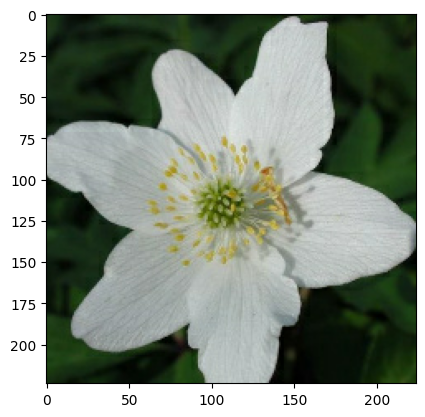

In [12]:
import random

import numpy as np


batch_imgs, batch_lbls = batch_train_tensors
batch_imgs_np = [(image.permute(1, 2, 0) * 255.0).numpy().astype(np.uint8) for image in batch_imgs]

rand_id = random.randrange(0, len(batch_imgs_np))
print(batch_lbls[rand_id])
plt.imshow(batch_imgs_np[rand_id])

In [13]:
xm.get_xla_supported_devices()

E0000 00:00:1724929472.708148      13 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:483


['xla:0', 'xla:1', 'xla:2', 'xla:3', 'xla:4', 'xla:5', 'xla:6', 'xla:7']

In [14]:
device = xm.xla_device() if xm.get_xla_supported_devices() else "cpu"
device
#

device(type='xla', index=0)

In [15]:
import math

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm


class xlm_fully_conv(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(start_dim=1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 104),
        )

    def forward(self, batch):
        return F.log_softmax(self.model(batch), dim=1)

In [16]:
xlm_model = xlm_fully_conv().to(device, dtype=torch.float32)
output = xlm_model(batch_train_tensors[0].to(device, dtype=torch.float32))

In [17]:
print(sorted(np.unique(torch.argmax(output, dim=1).detach().cpu().numpy())))

[5, 11, 12, 14, 15, 16, 21, 30, 31, 33, 35, 39, 52, 53, 60, 67, 69, 74, 75, 80, 87, 88, 89, 91, 92, 101]


In [18]:
import torch_xla.distributed.parallel_loader as pl
from sklearn import metrics
from tqdm import tqdm


xlm_model = xlm_fully_conv().to(device, dtype=torch.float32)

num_epochs = 100
loss = nn.NLLLoss()
opt = torch.optim.Adam(xlm_model.parameters(), lr=5e-3)
batch_size = 512
rate_tracker_train = xm.RateTracker()
rate_tracker_val = xm.RateTracker()

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    xlm_model.train()
    batch_generator_train = load_tensor_batches(
        load_dataset(get_recursive_paths(path, "train")), batch_size
    )
    train_loader = pl.ParallelLoader(batch_generator_train, [device])
    for i, train_batch in enumerate(train_loader.per_device_loader(xm.xla_device())):
        train_imgs, train_lbls = train_batch[0].to(device, dtype=torch.float32), train_batch[1].to(
            device, dtype=torch.float32
        )

        lbls_predict = xlm_model(train_imgs)
        output = loss(lbls_predict, train_lbls)
        output.backward()
        xm.optimizer_step(opt)
        opt.zero_grad()

        if i % 10 == 0:
            f1 = metrics.f1_score(
                train_lbls.detach().cpu().numpy(),
                torch.argmax(lbls_predict, dim=1).detach().cpu().numpy(),
                average="macro",
            )
            print(f"Loss: {output.detach().cpu()}")
            print(f"F1-score: {f1}")
            print(f"Rate: {rate_tracker_train.rate()} examples/sec")

        rate_tracker_train.add(batch_size)
        xm.mark_step()

    xlm_model.eval()
    batch_generator_val = load_tensor_batches(
        load_dataset(get_recursive_paths(path, "val")), batch_size
    )
    val_loader = pl.ParallelLoader(batch_generator_val, [device])
    losses, f1scores = list(), list()

    for i, val_batch in enumerate(val_loader.per_device_loader(xm.xla_device())):
        val_imgs, val_lbls = val_batch[0].to(device, dtype=torch.float32), val_batch[1].to(
            device, dtype=torch.float32
        )

        with torch.no_grad():
            lbls_predict = xlm_model(val_imgs)
            output = loss(lbls_predict, val_lbls)
            score = metrics.f1_score(
                val_lbls.detach().cpu().numpy(),
                torch.argmax(lbls_predict, dim=1).detach().cpu().numpy(),
                average="macro",
            )

        losses.append(output.detach().cpu())
        f1scores.append(score)
        rate_tracker_val.add(batch_size)

        xm.mark_step()

    print(f"Validation")
    print(f"Loss: {np.mean(np.array(losses))}")
    print(f"F1-score: {np.mean(np.array(f1scores))}")
    print(f"Rate: {rate_tracker_val.rate()} examples/sec")

Epoch: 0
Loss: 4.765623092651367
F1-score: 0.005401382243487507
Rate: 0.0 examples/sec
Loss: 3.684774875640869
F1-score: 0.01626965163550011
Rate: 56.47531194168979 examples/sec
Loss: 3.313911199569702
F1-score: 0.033159674319004885
Rate: 126.89606029264463 examples/sec
Validation
Loss: 3.594395160675049
F1-score: 0.026043571076470096
Rate: 25.509115354061844 examples/sec
Epoch: 1
Loss: 3.2866082191467285
F1-score: 0.04291271897788188
Rate: 87.32396016434225 examples/sec
Loss: 3.103058338165283
F1-score: 0.042286693155686984
Rate: 430.248199428196 examples/sec
Loss: 2.933185338973999
F1-score: 0.07540063303734444
Rate: 457.49778224281283 examples/sec
Validation
Loss: 3.4188637733459473
F1-score: 0.03889462098713196
Rate: 89.31914611280541 examples/sec
Epoch: 2
Loss: 2.9609811305999756
F1-score: 0.08811979127482426
Rate: 323.4056732188608 examples/sec
Loss: 2.877152442932129
F1-score: 0.0873093585972516
Rate: 517.5972083840616 examples/sec
Loss: 2.732288360595703
F1-score: 0.11108886511

KeyboardInterrupt: 

In [54]:
from collections import defaultdict

import pandas as pd


xlm_model.eval()
test_data = load_tensor_batches(
    load_dataset(get_recursive_paths(path, "test"), labeled=False), batch_size=1, labeled=False
)
test_dataframe = defaultdict(list)

for i, test_batch in enumerate(test_data):
    test_imgs, test_filename = test_batch[0].to(device, dtype=torch.float32), test_batch[1]
    lbls_predict = xlm_model(test_imgs)
    test_dataframe["id"].append(*test_filename)
    test_dataframe["label"].append(int(torch.argmax(lbls_predict, dim=1).detach().cpu().squeeze()))

In [55]:
solution = pd.DataFrame(test_dataframe).reset_index(drop=True)

In [56]:
solution.head(5)

,id,label
0,59d1b6146,46
1,48c96bd6b,73
2,7b437ba4e,9
3,1b7aef8e8,79
4,d6143b4d4,4


In [57]:
solution.to_csv(f"conv_baseline_solution.csv", index=False)